# WIREFIRE Analysis by Month

Purpose: Analyze pushed/reason alert type and location by month and county from January 2023 to July 2024.

By: Elsie Wang

Date: 08/11/2024

In [1]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors
import re

import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import HeatMap
from ipyleaflet import Map, Heatmap, LayerGroup, basemaps
import ipywidgets as widgets
from IPython.display import Image, display, clear_output

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/Users/elsiewang/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Read and Write Files

In [94]:
def merge_csv_files(folder_path, output_file):
    """
    Merges all CSV files in month into a single month CSV file.

    Parameters:
    folder_path (str): The path to the folder containing the CSV files.
    output_file (str): The path where the combined CSV file will be saved.

    Returns:
    None
    """
    # List all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize an empty DataFrame
    combined_df = pd.DataFrame()

    # Loop through the list of CSV files and append each to the combined DataFrame
    for file in csv_files:
        print(file)
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Save the combined DataFrame to a new CSV file
    combined_df.to_csv(output_file, index=False)

In [97]:
%%capture
def dms_to_decimal(dms_str, hemisphere):
    """
    Converts a DMS (Degrees, Minutes, Seconds) formatted string into decimal degrees.

    Parameters:
    - dms_str (str): The DMS formatted string (e.g., "35° 38.676'").
    - hemisphere (str): The hemisphere identifier ('N', 'S', 'E', 'W').

    Returns:
    - float: The decimal degree equivalent of the DMS string.
    """
    match = re.match(r'(\d+)°\s(\d+\.\d+)\'', dms_str.strip())
    if match:
        degrees, minutes = map(float, match.groups())
        decimal = degrees + minutes / 60
        if hemisphere in ['S', 'W']:
            decimal = -decimal
        return decimal
    return None


def process_lat_lon(lat_lon):
    """
    Processes a latitude/longitude string in either DMS or decimal format and converts it 
    into separate latitude and longitude values.

    Parameters:
    - lat_lon (str): The latitude/longitude string, either in DMS format 
                     (e.g., "N 35° 38.676' W 119° 57.851'") or decimal format 
                     (e.g., "34.2662449244796, -117.460262071904").

    Returns:
    - tuple: A tuple containing the latitude and longitude as floats (lat, lon).
    """
    if isinstance(lat_lon, str) and re.match(r'[NSEW]\s\d+°\s\d+\.\d+\'', lat_lon.strip()):
        # Split the DMS lat/lon into latitude and longitude parts
        lat_str = re.search(r'N\s\d+°\s\d+\.\d+\'', lat_lon)
        lon_str = re.search(r'W\s\d+°\s\d+\.\d+\'', lat_lon)
        
        if lat_str and lon_str:
            lat = dms_to_decimal(lat_str.group().replace('N ', ''), 'N')
            lon = dms_to_decimal(lon_str.group().replace('W ', ''), 'W')
            return lat, lon
    elif isinstance(lat_lon, str):
        try:
            lat, lon = map(float, lat_lon.split(','))
            return lat, lon
        except ValueError:
            return None, None
    return None, None

# Read all 2023 files into months
input_folder = 'data/pre_merged_data/'
output_folder = 'data/merged_data/'
year = '2023'

dataframes = {}

# Iterate over each month
for month in range(1, 13):
    month_str = f"{month:02}"
    folder_path = os.path.join(input_folder, f'{year}_{month_str}')
    output_file = os.path.join(output_folder, f'{year}_{month_str}.csv')

    if os.path.exists(folder_path):
        merge_csv_files(folder_path, output_file)
        # Load the merged CSV file into a DataFrame and store it in the dictionary
        df = pd.read_csv(output_file)
        
        # Process lat/lon column
        df[['lat', 'lon']] = df['lat/lon'].apply(lambda x: pd.Series(process_lat_lon(x)))
        
        dataframes[f'{year}_{month_str}'] = df

# Repeat the same for 2024 files up till June
year = '2024'

# Iterate over each month
for month in range(1, 8):
    month_str = f"{month:02}"
    folder_path = os.path.join(input_folder, f'{year}_{month_str}')
    output_file = os.path.join(output_folder, f'{year}_{month_str}.csv')

    if os.path.exists(folder_path):
        merge_csv_files(folder_path, output_file)
        # Load the merged CSV file into a DataFrame and store it in the dictionary
        df = pd.read_csv(output_file)
        
        # Process lat/lon column
        df[['lat', 'lon']] = df['lat/lon'].apply(lambda x: pd.Series(process_lat_lon(x)))
        
        dataframes[f'{year}_{month_str}'] = df

In [98]:
# CA county shapefile
counties = gpd.read_file('data/ca_counties/CA_Counties.shp')
counties.head()

STATEFP COUNTYFP  COUNTYNS  GEOID           NAME              NAMELSAD LSAD  \
0      06      091  00277310  06091         Sierra         Sierra County   06   
1      06      067  00277298  06067     Sacramento     Sacramento County   06   
2      06      083  00277306  06083  Santa Barbara  Santa Barbara County   06   
3      06      009  01675885  06009      Calaveras      Calaveras County   06   
4      06      111  00277320  06111        Ventura        Ventura County   06   

  CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT         ALAND        AWATER  \
0      H1  G4020  None   None     None        A  2.468695e+09  2.329911e+07   
1      H1  G4020   472  40900     None        A  2.499984e+09  7.542543e+07   
2      H1  G4020  None  42200     None        A  7.084063e+09  2.729752e+09   
3      H1  G4020  None   None     None        A  2.641785e+09  4.384187e+07   
4      H1  G4020   348  37100     None        A  4.771988e+09  9.473454e+08   

      INTPTLAT      INTPTLON     Shape_Leng    Shape_Area  \
0  +39.5769252  -120.5219926  375602.758281  4.200450e+09   
1  +38.4500161  -121.3404408  406584.174167  4.205516e+09   
2  +34.5370572  -120.0399729  891686.747247  1.449841e+10   
3  +38.1838996  -120.5614415  367005.879680  4.356213e+09   
4  +34.3587415  -119.1331432  527772.242190  8.413293e+09   

                                            geometry  
0  POLYGON ((-13431319.751 4821511.426, -13431312...  
1  POLYGON ((-13490651.476 4680831.603, -13490511...  
2  MULTIPOLYGON (((-13440081.316 4150394.004, -13...  
3  POLYGON ((-13428575.483 4627725.227, -13428534...  
4  MULTIPOLYGON (((-13283668.940 4059436.934, -13...

## Analysis Over Time

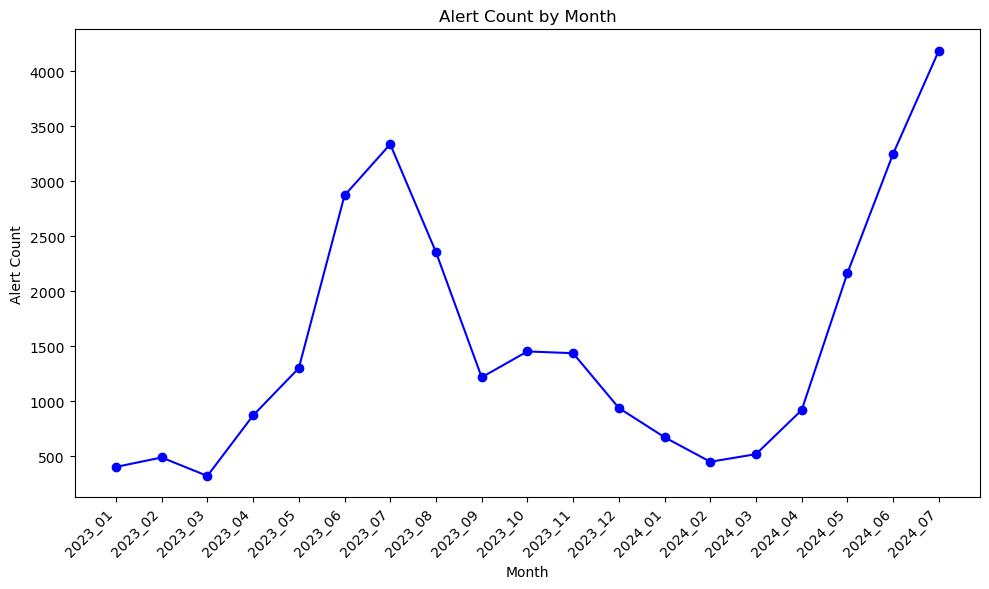

In [5]:
# Create line grpah of alert countsy by month

alert_counts = []

# Iterate through each month in the dataframes dictionary
for month, df in dataframes.items():
    alert_count = len(df)
    alert_counts.append((month, alert_count))

alert_counts.sort()

# Separate the months and counts into two lists for plotting
months, counts = zip(*alert_counts)

# Create a line graph
plt.figure(figsize=(10, 6))
plt.plot(months, counts, marker='o', linestyle='-', color='b')
plt.title('Alert Count by Month')
plt.xlabel('Month')
plt.ylabel('Alert Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the line graph
plt.show()

In [6]:
# Exclude specific reasons and combine 'solar' and 'solar farm'
def process_reason(reason):
    if pd.isna(reason):  # Check for NaN values
        return None
    reason = str(reason).lower()  # Convert to string and lowercase
    if reason in ['de6f80b6-dc72-4bdb-801b-f82c0f131e8c', 'c1257705-5062-4d73-b018-145573a0457c', '4166358f-4646-4d3b-a2b1-275d63a1c9ed']:
        return None  # Exclude these reasons
    if reason in ['solar', 'solar farm']:
        return 'solar / solar farm'  # Combine solar and solar farm
    return reason

monthly_reason_counts = {}

# Iterate through each month in the dataframes dictionary
for month, df in dataframes.items():
    df['pushed/reason'] = df['pushed/reason'].apply(process_reason)
    reason_counts = df['pushed/reason'].value_counts(dropna=True)
    monthly_reason_counts[month] = reason_counts

# Create a DataFrame from the monthly_reason_counts dictionary
reason_counts_df = pd.DataFrame(monthly_reason_counts).fillna(0).T

# Reset the index to have months as a column
reason_counts_df = reason_counts_df.reset_index().rename(columns={'index': 'Month'})

# Melt the DataFrame to long format for plotly
melted_df = reason_counts_df.melt(id_vars='Month', var_name='Reason', value_name='Count')

# Generate a diverse color palette for reasons
unique_reasons = melted_df['Reason'].unique()
num_reasons = len(unique_reasons)
color_palette = plotly.colors.qualitative.Safe + plotly.colors.qualitative.Pastel + plotly.colors.qualitative.D3
color_palette = color_palette[:num_reasons]
color_mapping = {reason: color for reason, color in zip(unique_reasons, color_palette)}

# Create a stacked bar chart using plotly
fig = px.bar(melted_df, x='Month', y='Count', color='Reason', title='Pushed/Reason Counts by Month', 
             labels={'Month': 'Month', 'Count': 'Alert Count', 'Reason': 'Pushed/Reason'},
             color_discrete_map=color_mapping)

# Update layout for better visualization
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'category ascending'}, legend_title_text='Pushed/Reason')

# Show the figure
fig.show()

## Analysis for Each Month

Create functions to perform analysis for any month/year pair.

In [7]:
def create_alerts_heatmap(dataframes: dict, counties_gdf: gpd.GeoDataFrame, default_month: str = None) -> None:
    """
    Create heatmaps of alert counts with a dropdown menu to filter by 'pushed/reason',
    ensuring consistent color scale across all heatmaps. The default month can be specified.

    Parameters:
    dataframes (dict): Dictionary where keys are month/year strings and values are DataFrames 
                       containing alert data with 'lat/lon' columns.
    counties_gdf (gpd.GeoDataFrame): GeoDataFrame containing county boundaries.
    default_month (str): Optional; The default month/year string to be pre-selected in the month dropdown.
    """
    # Combine all dataframes to find the global max intensity for consistent scaling
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    combined_df = combined_df.dropna(subset=['lat', 'lon'])
    
    # Calculate global maximum intensity across all data
    global_max_intensity = combined_df.groupby(['lat', 'lon']).size().max().item()  # Convert to Python int

    # Initial map setup
    map_output = widgets.Output()
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

    def update_heatmap(reason, selected_month, counties_gdf):
        with map_output:
            clear_output(wait=True)
            
            # Get the selected dataframe and drop NaN values in lat/lon
            dataframe = dataframes[selected_month].dropna(subset=(['lat', 'lon']))

            # Debugging: Print reason and selected month
            print(f"Selected Month: {selected_month}")
            print(f"Selected Reason: {reason}")

            # Filter data based on reason
            if reason == 'Total':
                filtered_data = dataframe
            else:
                filtered_data = dataframe[dataframe['pushed/reason'] == reason]
                
            heat_data = filtered_data[['lat', 'lon']].values.tolist()
            print(f"Number of Alerts: {len(heat_data)}")

            # Normalize heat data intensity by global maximum
            heat_data_normalized = [[point[0], point[1], 1 / global_max_intensity] for point in heat_data]

            # Clear the existing map
            m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

            # Add heat map layer with normalized data
            if heat_data_normalized:
                HeatMap(heat_data_normalized, min_opacity=0.2, max_zoom=18).add_to(m)
            else:
                print("No valid data to display on the heatmap.")

            # Perform the spatial join to assign filtered alerts to counties
            alerts_gdf = gpd.GeoDataFrame(filtered_data, geometry=gpd.points_from_xy(filtered_data.lon, filtered_data.lat))
            alerts_gdf.set_crs(epsg=4326, inplace=True)
            counties_gdf = counties_gdf.to_crs(epsg=4326)
            alerts_in_counties = gpd.sjoin(alerts_gdf, counties_gdf, how='inner', op='within')

            # Count the number of alerts per county for the filtered reason
            alerts_count_by_county = alerts_in_counties.groupby('NAME').size().reset_index(name='alerts_count')
            counties_gdf_merged = counties_gdf.merge(alerts_count_by_county, how='left', left_on='NAME', right_on='NAME')
            counties_gdf_merged['alerts_count'] = counties_gdf_merged['alerts_count'].fillna(0).astype(int)  # Convert to Python int

            # Add the counties layer with alert counts and tooltips
            folium.GeoJson(
                counties_gdf_merged,
                style_function=lambda x: {
                    'fillColor': 'green',
                    'color': 'black',
                    'weight': 0.5,
                    'fillOpacity': 0.2
                },
                tooltip=folium.GeoJsonTooltip(
                    fields=['NAME', 'alerts_count'],
                    aliases=['County', 'Alert Count'],
                    localize=True
                )
            ).add_to(m)

            display(m)

    # Dropdown widget for selecting the month
    month_options = list(dataframes.keys())
    month_dropdown = widgets.Dropdown(options=month_options, description='Month:', value=default_month)

    # Dropdown widget for selecting the reason
    reasons = ['Total'] + combined_df['pushed/reason'].dropna().unique().tolist()
    dropdown = widgets.Dropdown(options=reasons, description='Reason:')

    # Combine the dropdowns into a single interactive widget
    ui = widgets.VBox([month_dropdown, dropdown])

    # Interactive widget to link the dropdowns to the update function
    interactive = widgets.interactive_output(update_heatmap, {'selected_month': month_dropdown, 'reason': dropdown, 'counties_gdf': widgets.fixed(counties_gdf)})
    
    # Display the UI and interactive map
    display(ui, map_output, interactive)

    # Initial display of the map
    initial_month = default_month if default_month else month_options[0]
    update_heatmap('Total', initial_month, counties_gdf)

In [8]:
def get_alerts_statistics(dataframe, counties_gdf):
    """
    Calculate statistics from alerts data and create visualizations.

    Parameters:
    dataframe (pd.DataFrame): DataFrame containing alert data with 'lat/lon' and 'pushed/reason' columns.
    counties_gdf (gpd.GeoDataFrame): GeoDataFrame containing county boundaries.

    Returns:
    dict: A dictionary containing total alert count, average alert count, 
          county with the most alerts, most common reason for alerts, 
          count of the most common reason, and file paths to generated charts.
    """

    dataframe[['lat', 'lon']] = dataframe['lat/lon'].str.split(',', expand=True)
    dataframe['lat'] = pd.to_numeric(dataframe['lat'], errors='coerce')
    dataframe['lon'] = pd.to_numeric(dataframe['lon'], errors='coerce')
    dataframe = dataframe.dropna(subset=['lat', 'lon'])

    # Convert alerts data to gdf
    alerts_gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.lon, dataframe.lat))

    # Set both gdfs to EPSG:4326
    alerts_gdf.set_crs(epsg=4326, inplace=True)
    counties_gdf = counties_gdf.to_crs(epsg=4326)

    # Perform the spatial join assign alerts to counties
    alerts_in_counties = gpd.sjoin(alerts_gdf, counties_gdf, how='inner', op='within')

    # Count number of alerts per county
    alerts_count_by_county = alerts_in_counties.groupby('NAME').size().reset_index(name='alerts_count')

    # Get total alert count
    total_alert_count = len(dataframe)

    # Get average alert count
    average_alert_count = alerts_count_by_county['alerts_count'].mean()

    # Get county with the most alerts
    county_most_alerts = alerts_count_by_county.loc[alerts_count_by_county['alerts_count'].idxmax()]

    # Get reason with the most alerts (excluding null)
    most_common_reason_series = dataframe['pushed/reason'].dropna().value_counts()
    most_common_reason = most_common_reason_series.idxmax()
    most_common_reason_count = most_common_reason_series.max()

    # Bar chart of 'pushed/reason' distribution including null counts
    pushed_reason_counts = dataframe['pushed/reason'].value_counts(dropna=False)
    plt.figure(figsize=(10, 6))
    pushed_reason_counts.plot(kind='bar', color='skyblue')
    plt.title('Distribution of Pushed/Reason')
    plt.xlabel('Pushed/Reason')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('pushed_reason_distribution.png')
    plt.close()

    # Bar chart of the distribution of county alerts
    plt.figure(figsize=(10, 6))
    alerts_count_by_county.set_index('NAME')['alerts_count'].sort_values(ascending=False).plot(kind='bar', color='lightgreen')
    plt.title('Distribution of Alerts by County')
    plt.xlabel('County')
    plt.ylabel('Alert Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('county_alerts_distribution.png')
    plt.close()

    # Return stats and file paths to charts
    stats = {
        'total_alert_count': total_alert_count,
        'average_alert_count': average_alert_count,
        'county_most_alerts': county_most_alerts,
        'most_common_reason': most_common_reason,
        'most_common_reason_count': most_common_reason_count,
        'pushed_reason_distribution_chart': 'pushed_reason_distribution.png',
        'county_alerts_distribution_chart': 'county_alerts_distribution.png'
    }

    return stats

In [9]:
def create_alerts_choropleth(dataframes: dict, counties_gdf: gpd.GeoDataFrame, default_month: str = None):
    """
    Create a choropleth map of alerts with dropdowns to filter by month and 'pushed/reason'.
    The choropleth map is scaled consistently across all months and reasons.

    Parameters:
    dataframes (dict): Dictionary where keys are month/year strings and values are DataFrames 
                       containing alert data with 'lat/lon' columns.
    counties_gdf (gpd.GeoDataFrame): GeoDataFrame containing county boundaries.
    default_month (str): Optional; The default month/year string to be pre-selected in the month dropdown.
    """
    # Combine all dataframes to find the global max intensity for consistent scaling
    combined_df = pd.concat(dataframes.values(), ignore_index=True)
    combined_df = combined_df.dropna(subset=['lat', 'lon'])

    # Ensure counties_gdf is in the correct CRS (WGS 84 - EPSG:4326)
    counties_gdf = counties_gdf.to_crs(epsg=4326)

    # Compute global maximum number of alerts for any county
    max_alerts_per_county = 0
    for df in dataframes.values():
        df_filtered = df.dropna(subset=['lat', 'lon'])
        alerts_gdf = gpd.GeoDataFrame(df_filtered, geometry=gpd.points_from_xy(df_filtered.lon, df_filtered.lat))
        alerts_gdf.set_crs(epsg=4326, inplace=True)
        alerts_in_counties = gpd.sjoin(alerts_gdf, counties_gdf, how='inner', op='within')
        alerts_count_by_county = alerts_in_counties.groupby('NAME').size()
        max_alerts_per_county = max(max_alerts_per_county, alerts_count_by_county.max())

    # Initial map setup
    map_output = widgets.Output()
    m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

    def update_choropleth(selected_month, reason):
        with map_output:
            clear_output(wait=True)
            m = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

            # Get the selected dataframe and filter based on the reason
            dataframe = dataframes[selected_month].copy()
            dataframe = dataframe.dropna(subset=['lat', 'lon'])

            if reason != 'Total':
                dataframe = dataframe[dataframe['pushed/reason'] == reason]

            # Convert alerts data to gdf
            alerts_gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.lon, dataframe.lat))
            alerts_gdf.set_crs(epsg=4326, inplace=True)

            # Perform the spatial join to assign alerts to counties
            alerts_in_counties = gpd.sjoin(alerts_gdf, counties_gdf, how='inner', op='within')

            # Count the number of alerts per county
            alerts_count_by_county = alerts_in_counties.groupby('NAME').size().reset_index(name='alerts_count')

            # Merge with counties GeoDataFrame
            counties_gdf_merged = counties_gdf.merge(alerts_count_by_county, how='left', left_on='NAME', right_on='NAME')
            counties_gdf_merged['alerts_count'] = counties_gdf_merged['alerts_count'].fillna(0)

            # Define color range with more variations
            color_scale = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#08306b']
            thresholds = [0, max_alerts_per_county * 0.1, max_alerts_per_county * 0.2, max_alerts_per_county * 0.3,
                          max_alerts_per_county * 0.4, max_alerts_per_county * 0.5, max_alerts_per_county * 0.6,
                          max_alerts_per_county * 0.7, max_alerts_per_county]

            # Add the choropleth layer with more color variations
            folium.Choropleth(
                geo_data=counties_gdf_merged,
                data=alerts_count_by_county,
                columns=['NAME', 'alerts_count'],
                key_on='feature.properties.NAME',
                fill_color='YlOrRd',  # Set this to 'YlOrRd' for a built-in color scheme or use 'color_scale' for custom colors
                fill_opacity=0.7,
                line_opacity=0.2,
                line_weight=0.2,
                threshold_scale=thresholds,
                legend_name='Number of Alerts'
            ).add_to(m)

            # Add tooltip
            folium.GeoJson(
                counties_gdf_merged,
                style_function=lambda x: {'fillColor': 'transparent', 'color': 'black', 'weight': 0.2},
                tooltip=folium.GeoJsonTooltip(
                    fields=['NAME', 'alerts_count'],
                    aliases=['County', 'Alert Count'],
                    localize=True
                )
            ).add_to(m)

            display(m)

    # Dropdown widgets
    month_options = list(dataframes.keys())
    month_dropdown = widgets.Dropdown(options=month_options, description='Month:', value=default_month if default_month else month_options[0])
    reasons = ['Total'] + combined_df['pushed/reason'].dropna().unique().tolist()
    reason_dropdown = widgets.Dropdown(options=reasons, description='Reason:')

    # Interactive widget
    interactive = widgets.interactive(update_choropleth, selected_month=month_dropdown, reason=reason_dropdown)
    display(interactive)

    # Display the map output
    display(map_output)

    # Initial display of the map
    initial_month = default_month if default_month else month_options[0]
    update_choropleth(initial_month, 'Total')

### January 2023

In [10]:
# Get jan dataframe
df = dataframes['2023_01']

In [11]:
create_alerts_heatmap(dataframes, counties, '2023_01')

Output()

Output()

In [12]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_01')

interactive(children=(Dropdown(description='Month:', options=('2023_01', '2023_02', '2023_03', '2023_04', '202…

Output()

Total Alert Count: 381
Average Alert Count: 16.52173913043478
County with Most Alerts: Riverside with 239 alerts
Most Common Reason for Alerts: urban with 91 alerts


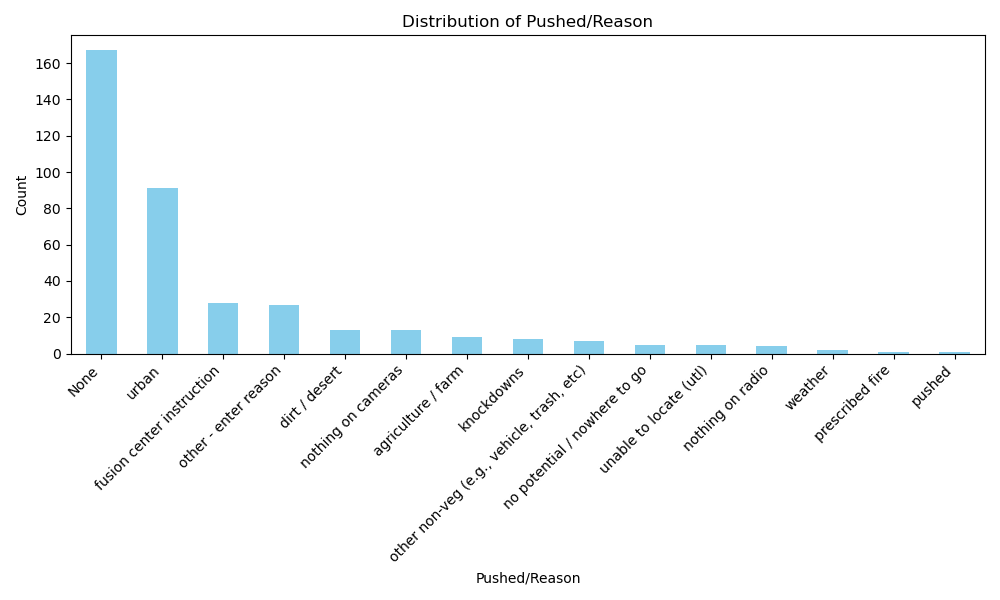

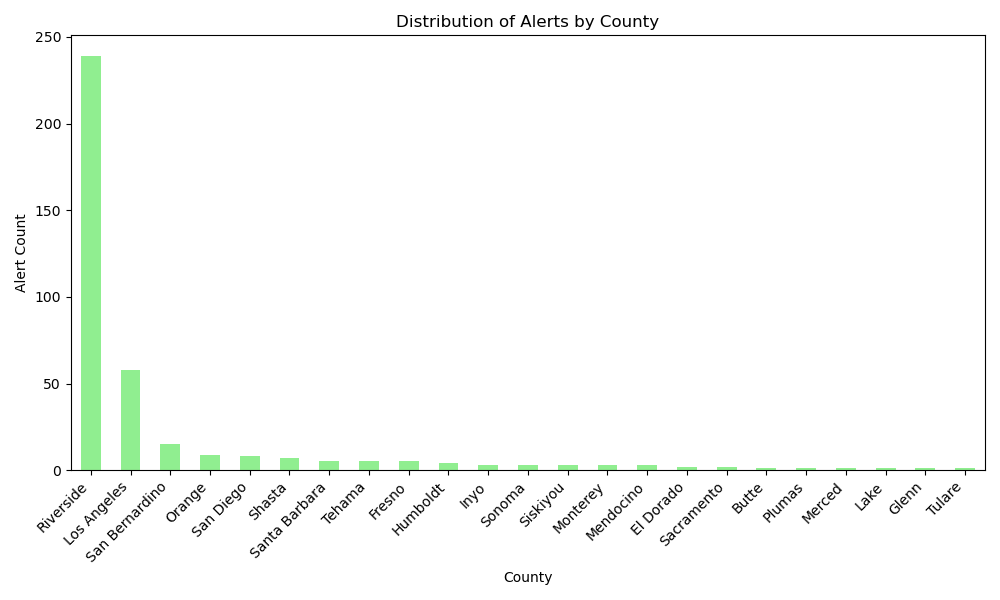

In [13]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### February 2023

In [14]:
# Get feb dataframe
df = dataframes['2023_02']

In [15]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_02')

Output()

Output()

In [16]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_02')

interactive(children=(Dropdown(description='Month:', index=1, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 469
Average Alert Count: 13.027777777777779
County with Most Alerts: Riverside with 212 alerts
Most Common Reason for Alerts: urban with 101 alerts


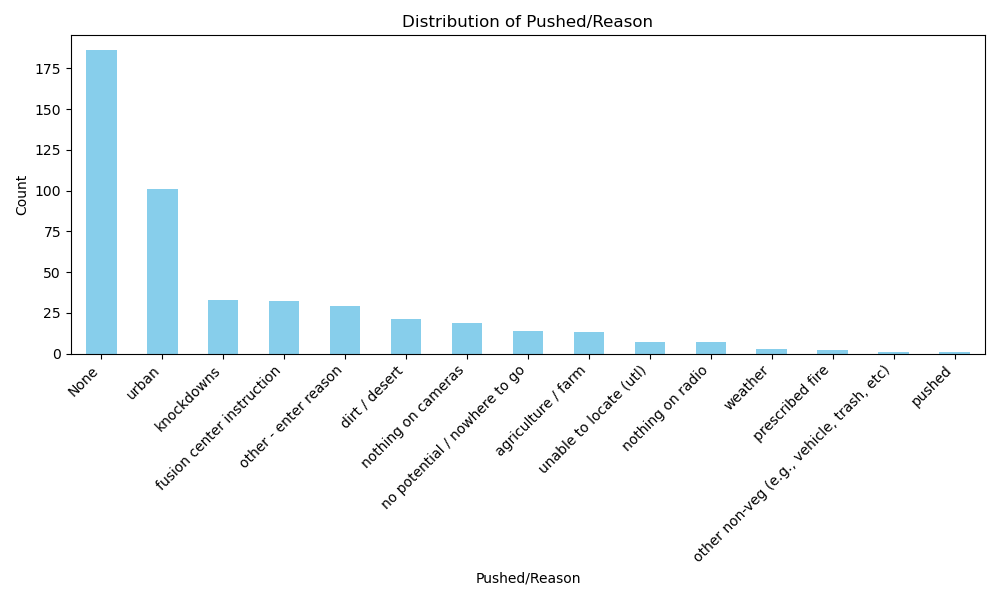

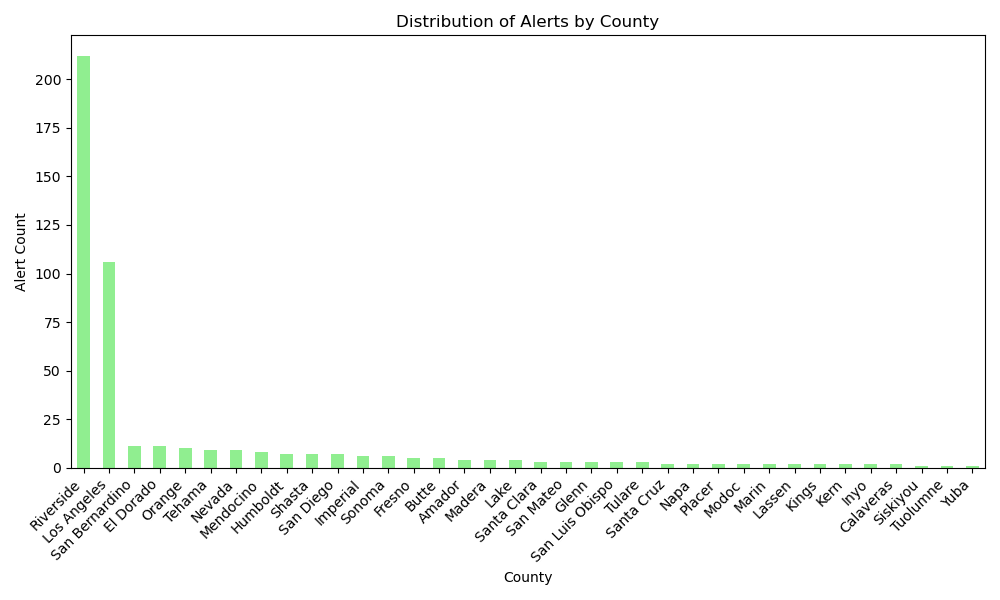

In [17]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### March 2023

In [18]:
# Get march dataframe
df = dataframes['2023_03']

In [19]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_03')

Output()

Output()

In [20]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_03')

interactive(children=(Dropdown(description='Month:', index=2, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 309
Average Alert Count: 10.655172413793103
County with Most Alerts: Riverside with 183 alerts
Most Common Reason for Alerts: urban with 43 alerts


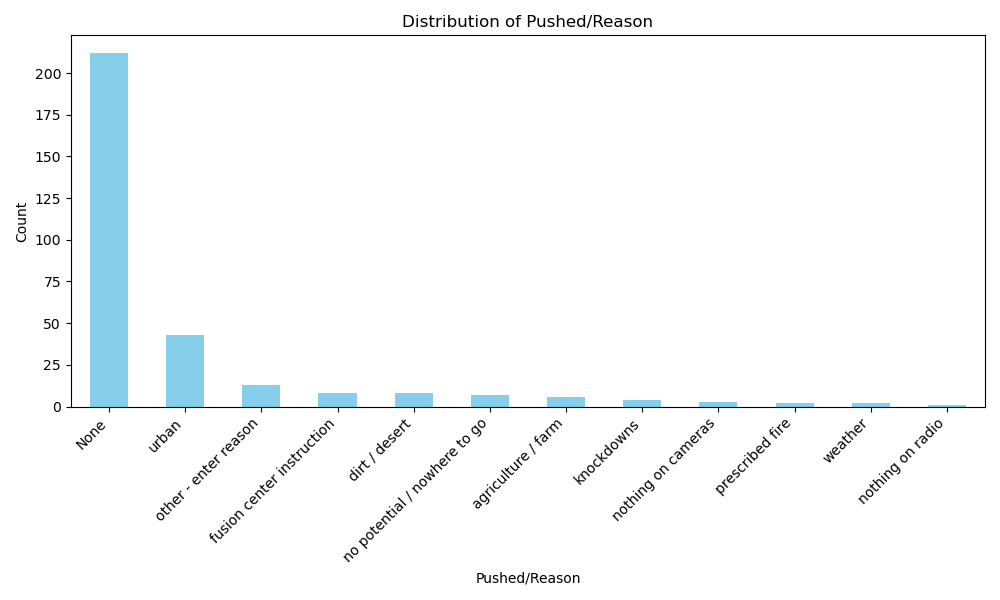

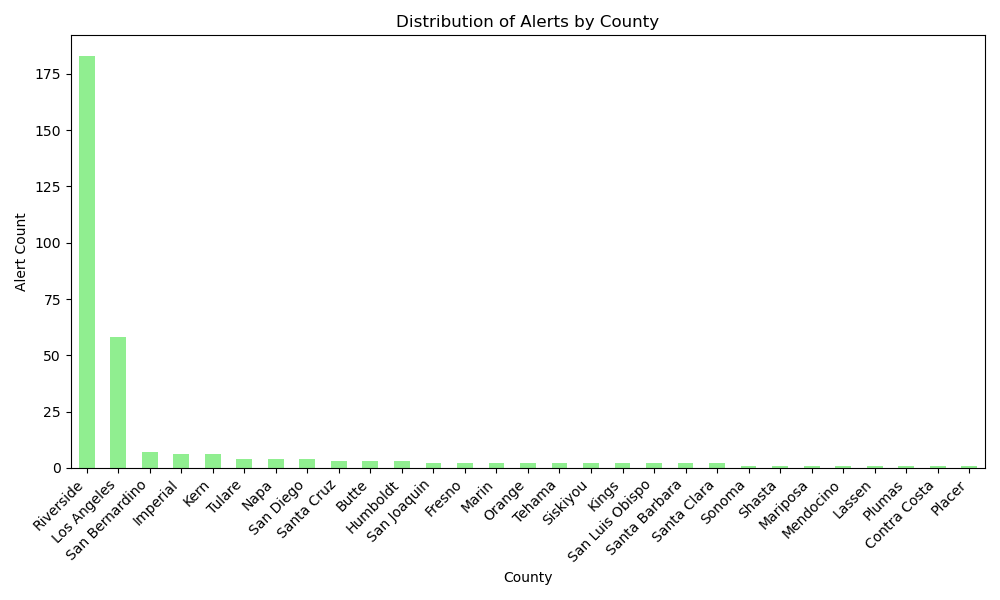

In [21]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### April 2023

In [22]:
# Get april dataframe
df = dataframes['2023_04']

In [23]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_04')

Output()

Output()

In [24]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_04')

interactive(children=(Dropdown(description='Month:', index=3, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 860
Average Alert Count: 16.647058823529413
County with Most Alerts: Riverside with 282 alerts
Most Common Reason for Alerts: urban with 113 alerts


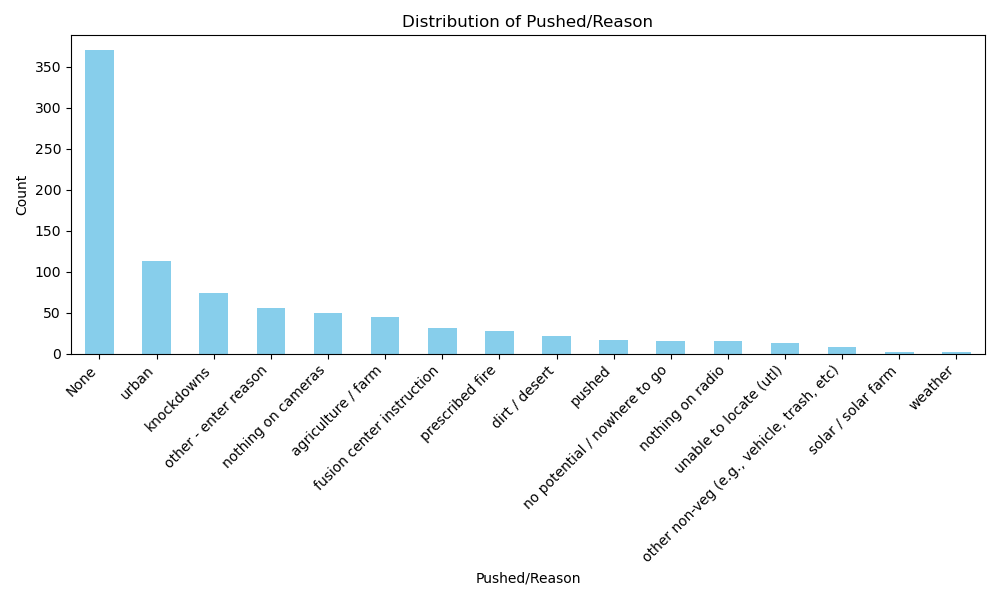

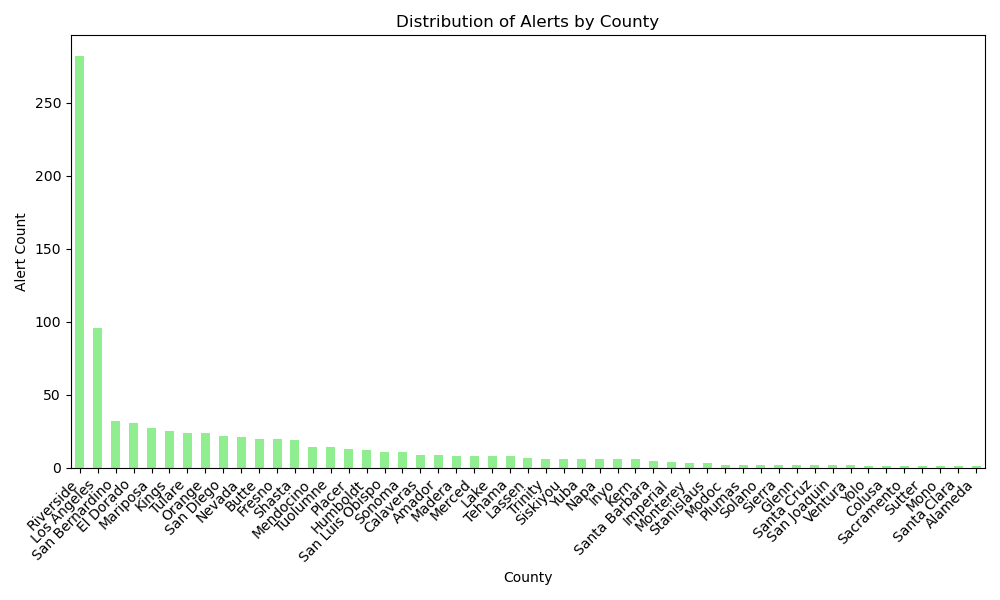

In [25]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### May 2023

In [26]:
# Get may dataframe
df = dataframes['2023_05']

In [27]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_05')

Output()

Output()

In [28]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_05')

interactive(children=(Dropdown(description='Month:', index=4, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 1290
Average Alert Count: 24.339622641509433
County with Most Alerts: Riverside with 340 alerts
Most Common Reason for Alerts: urban with 153 alerts


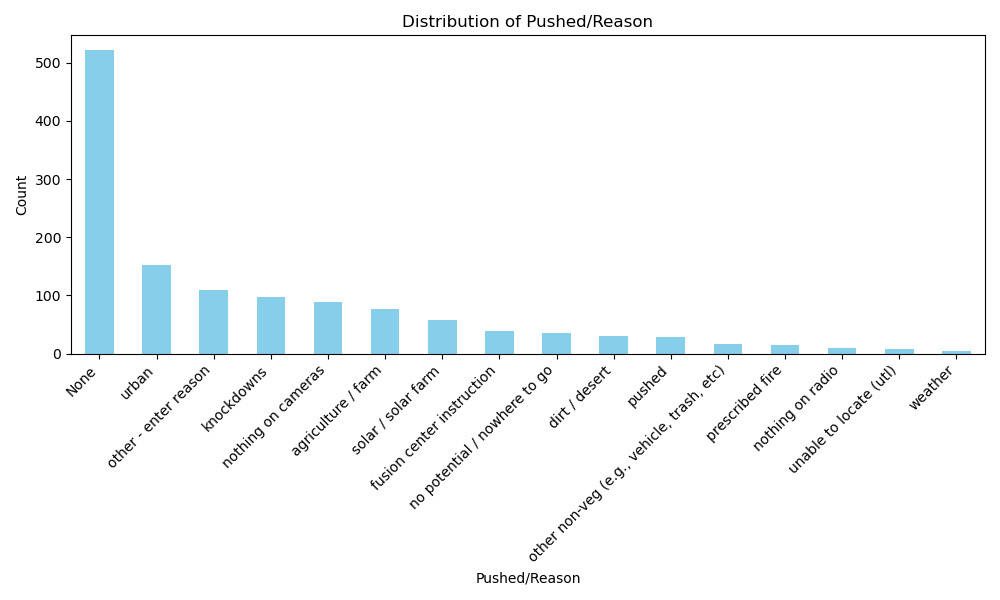

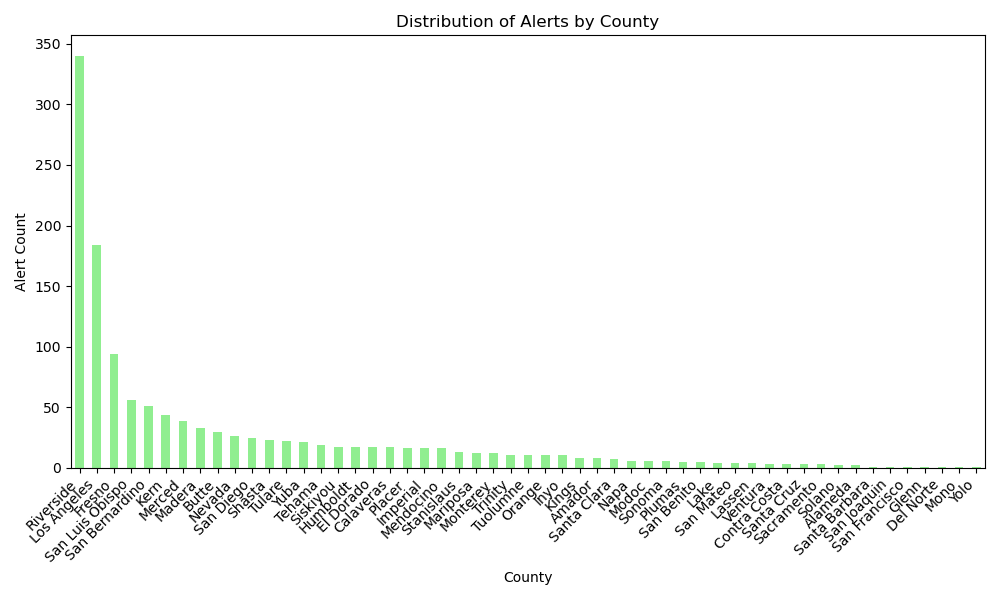

In [29]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### June 2023

In [30]:
# Get june dataframe
df = dataframes['2023_06']

In [31]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_06')

Output()

Output()

In [32]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_06')

interactive(children=(Dropdown(description='Month:', index=5, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 2806
Average Alert Count: 49.80357142857143
County with Most Alerts: Riverside with 532 alerts
Most Common Reason for Alerts: knockdowns with 355 alerts


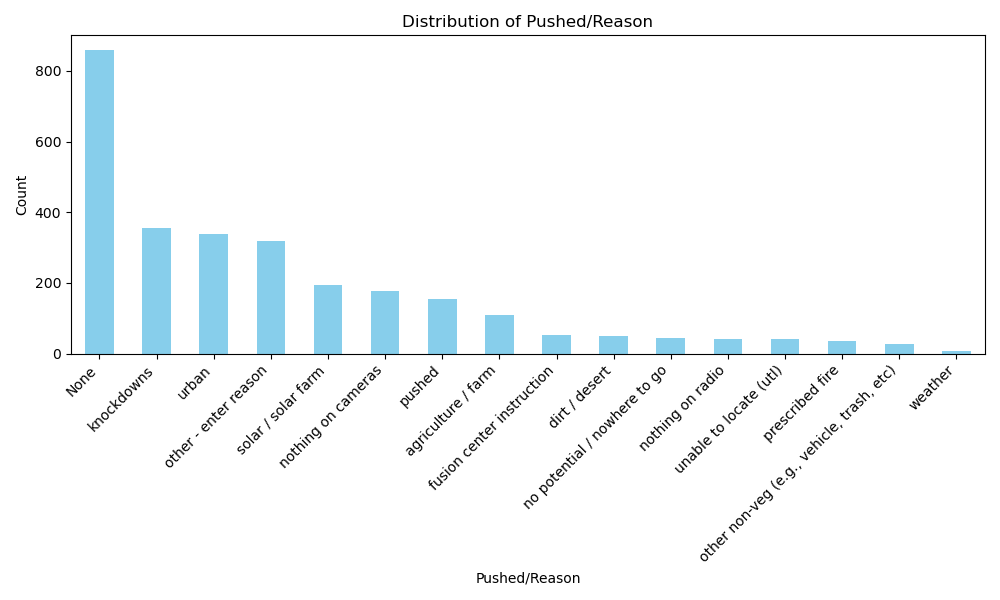

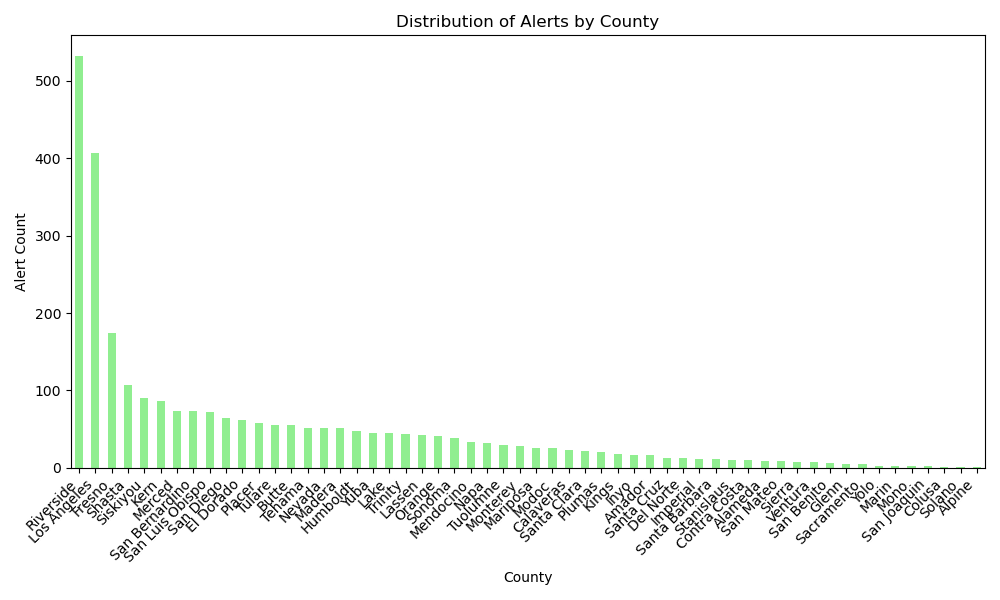

In [33]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### July 2023

In [34]:
# Get july dataframe
df = dataframes['2023_07']

In [35]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_07')

Output()

Output()

In [36]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_07')

interactive(children=(Dropdown(description='Month:', index=6, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 3207
Average Alert Count: 56.0
County with Most Alerts: Riverside with 749 alerts
Most Common Reason for Alerts: knockdowns with 445 alerts


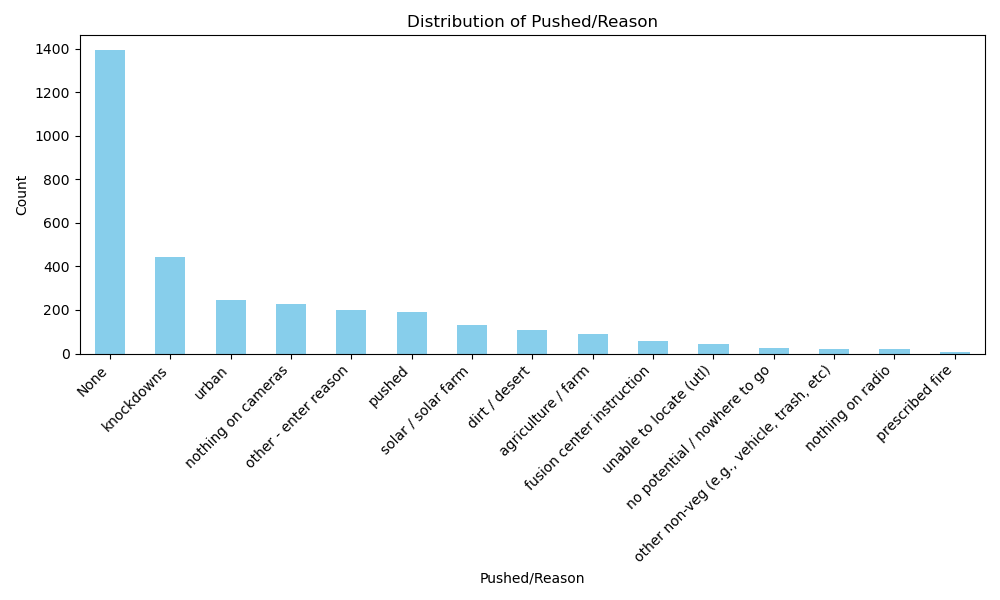

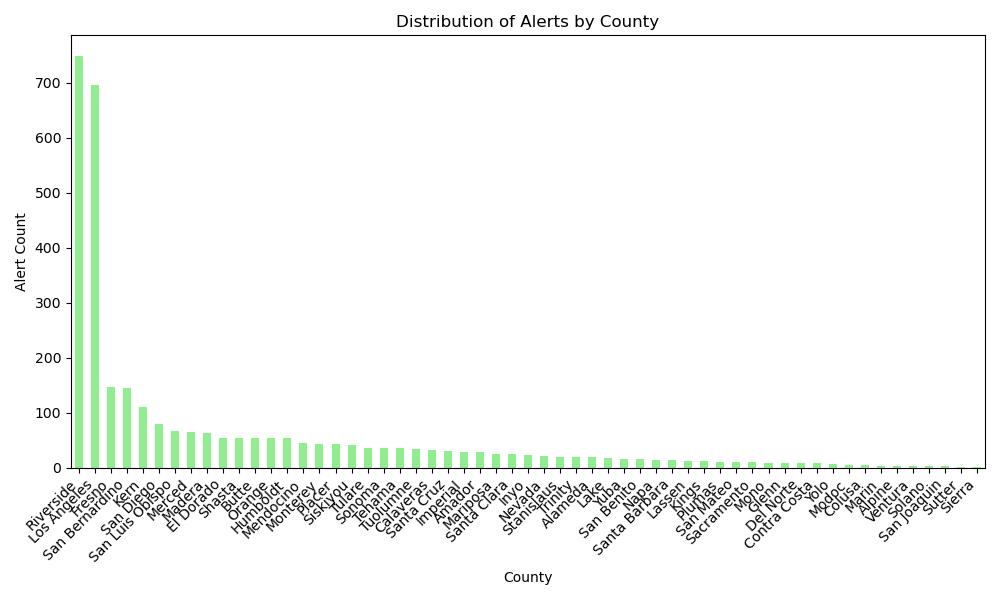

In [37]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### August 2023

In [38]:
# Get aug dataframe
df = dataframes['2023_08']

In [39]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_08')

Output()

Output()

In [40]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_08')

interactive(children=(Dropdown(description='Month:', index=7, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 2271
Average Alert Count: 40.44642857142857
County with Most Alerts: Riverside with 333 alerts
Most Common Reason for Alerts: nothing on cameras with 291 alerts


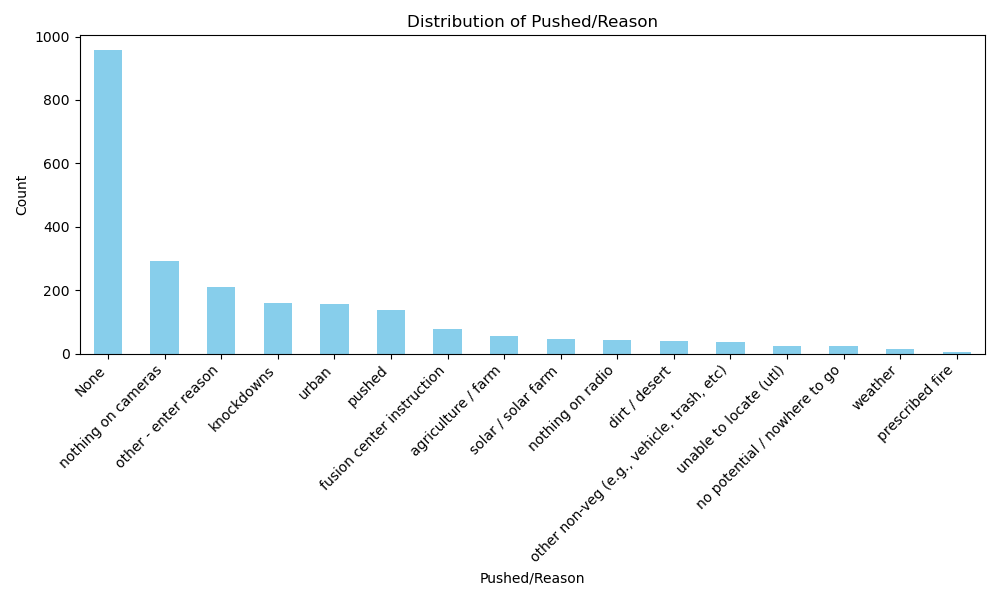

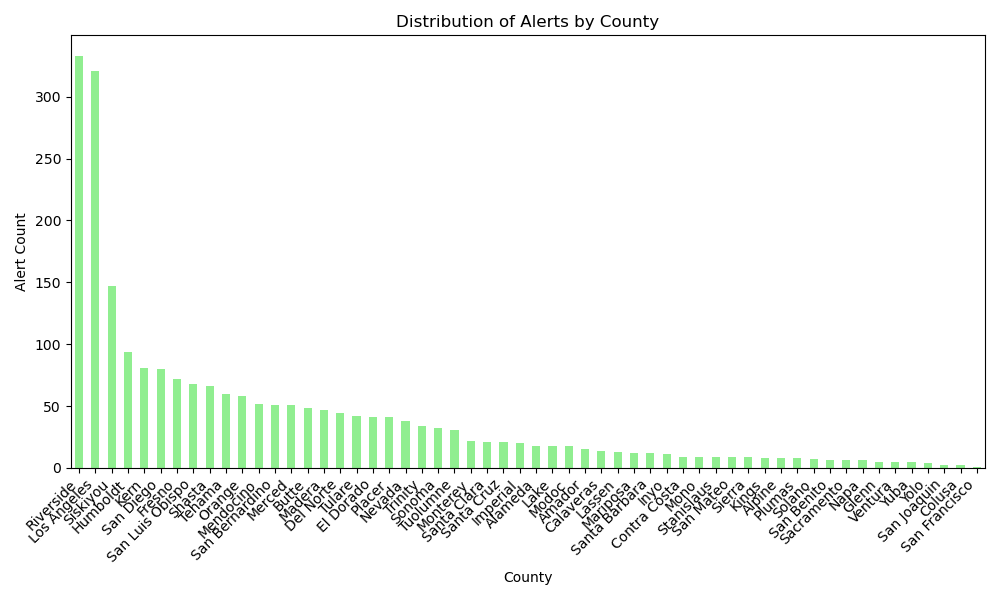

In [41]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### September 2023

In [42]:
# Get sept dataframe
df = dataframes['2023_09']

In [43]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_09')

Output()

Output()

In [44]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_09')

interactive(children=(Dropdown(description='Month:', index=8, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 1174
Average Alert Count: 21.327272727272728
County with Most Alerts: Riverside with 262 alerts
Most Common Reason for Alerts: nothing on cameras with 129 alerts


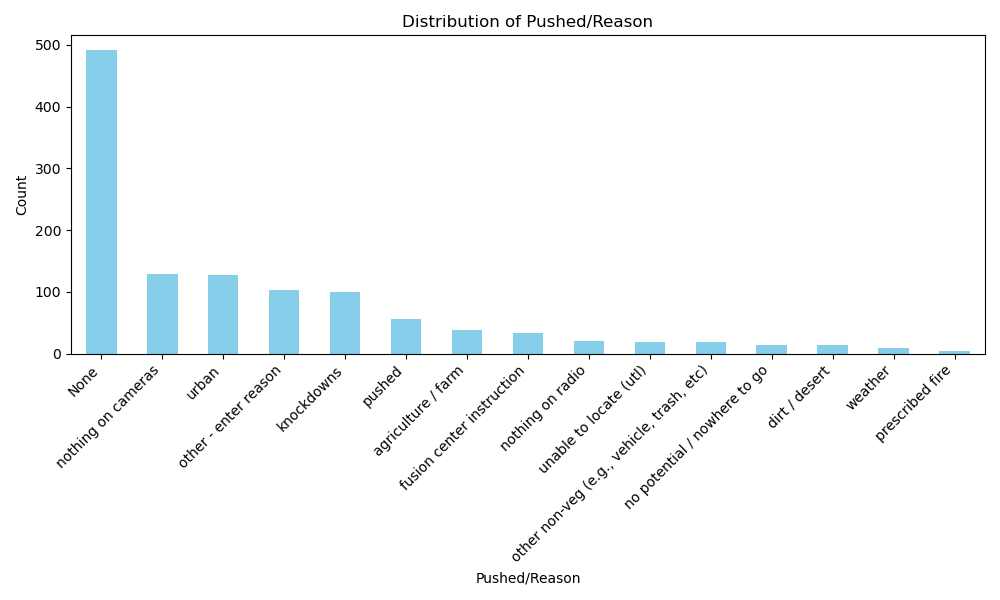

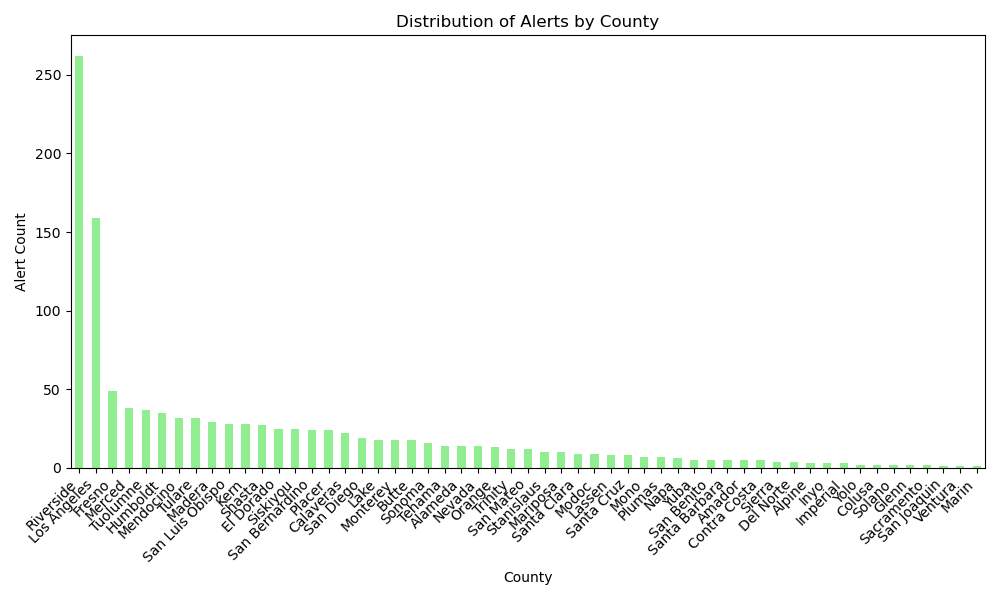

In [45]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### October 2023

In [46]:
# Get oct dataframe
df = dataframes['2023_10']

In [47]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_10')

Output()

Output()

In [48]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_10')

interactive(children=(Dropdown(description='Month:', index=9, options=('2023_01', '2023_02', '2023_03', '2023_…

Output()

Total Alert Count: 1381
Average Alert Count: 24.087719298245613
County with Most Alerts: Los Angeles with 373 alerts
Most Common Reason for Alerts: urban with 200 alerts


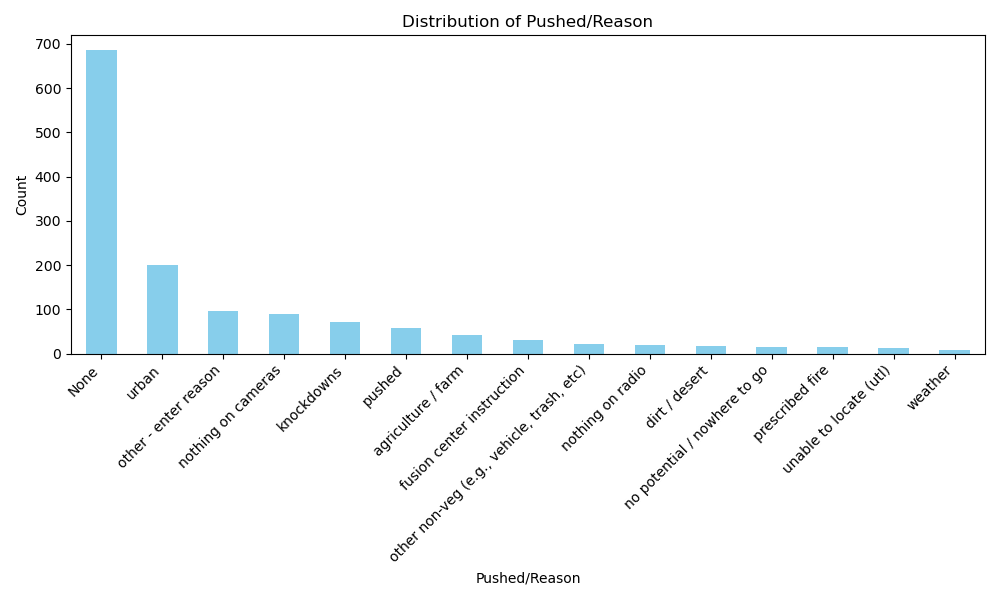

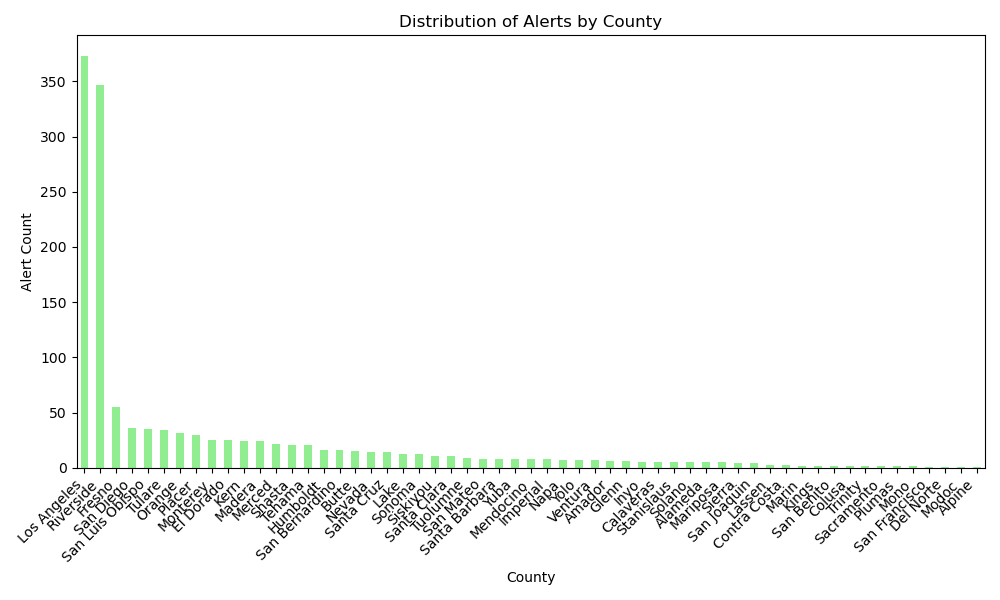

In [49]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### November 2023

In [50]:
# Get nov dataframe
df = dataframes['2023_11']

In [51]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_11')

Output()

Output()

In [52]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_11')

interactive(children=(Dropdown(description='Month:', index=10, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 1394
Average Alert Count: 27.76
County with Most Alerts: Los Angeles with 515 alerts
Most Common Reason for Alerts: urban with 321 alerts


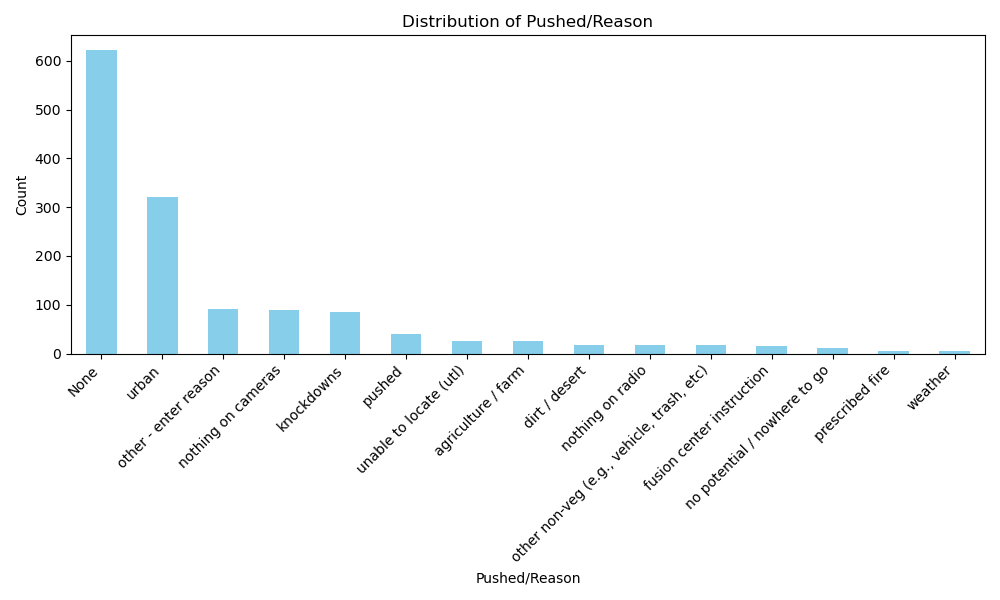

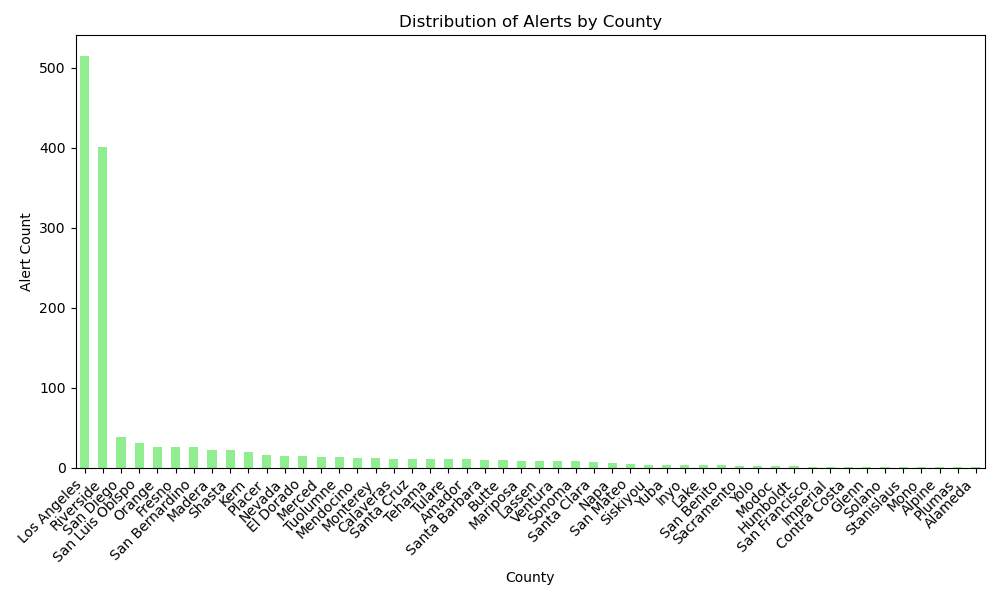

In [53]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### December 2023

In [54]:
# Get dec dataframe
df = dataframes['2023_12']

In [55]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2023_12')

Output()

Output()

In [56]:
# Get alert count choropleth
create_alerts_choropleth(dataframes, counties, '2023_12')

interactive(children=(Dropdown(description='Month:', index=11, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 898
Average Alert Count: 21.878048780487806
County with Most Alerts: Los Angeles with 340 alerts
Most Common Reason for Alerts: urban with 209 alerts


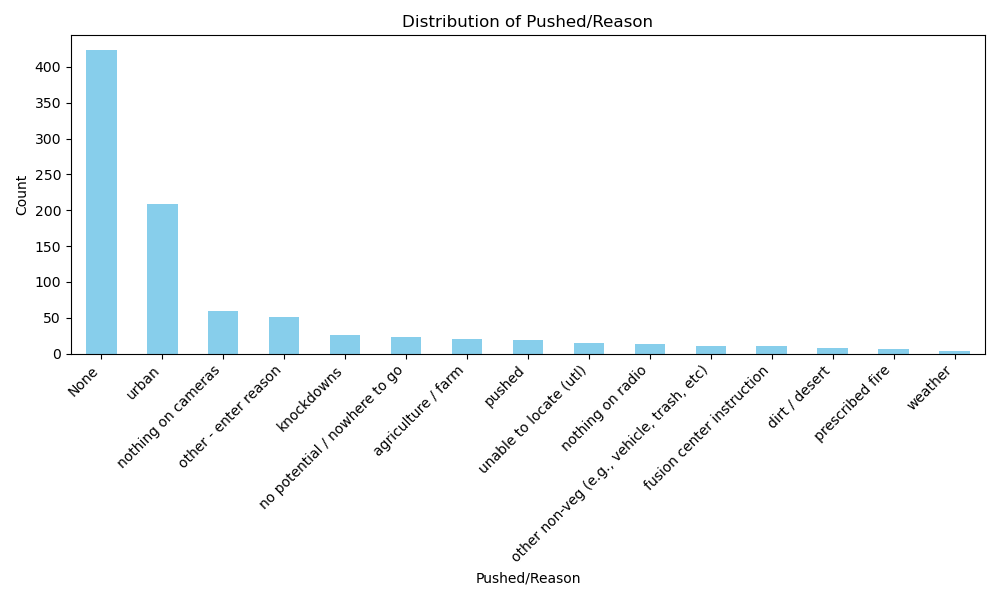

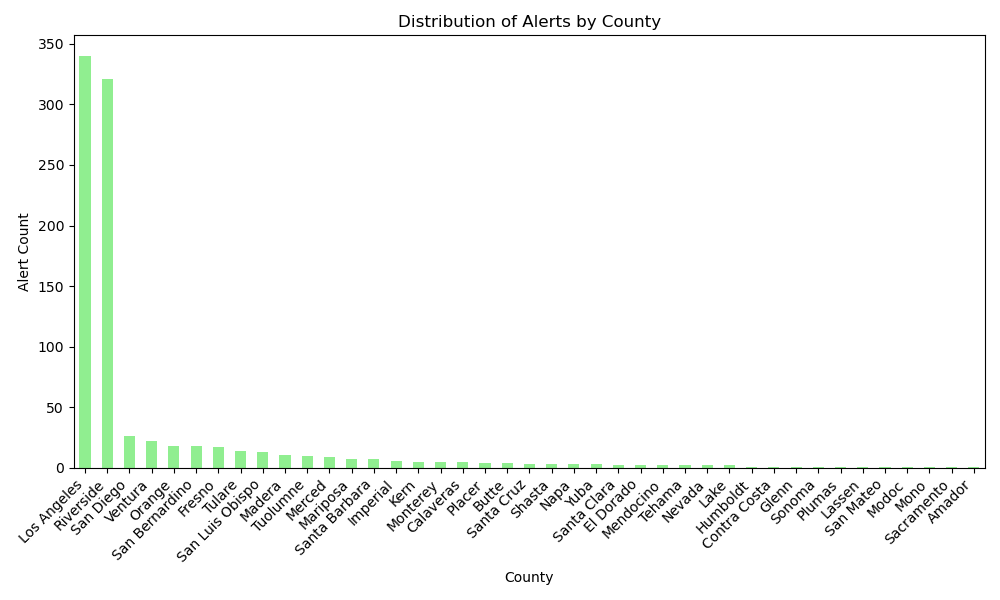

In [57]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### January 2024

In [58]:
# Get jan dataframe
df = dataframes['2024_01']

In [59]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2024_01')

Output()

Output()

In [60]:
create_alerts_choropleth(dataframes, counties, '2024_01')

interactive(children=(Dropdown(description='Month:', index=12, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 656
Average Alert Count: 23.428571428571427
County with Most Alerts: Riverside with 321 alerts
Most Common Reason for Alerts: urban with 150 alerts


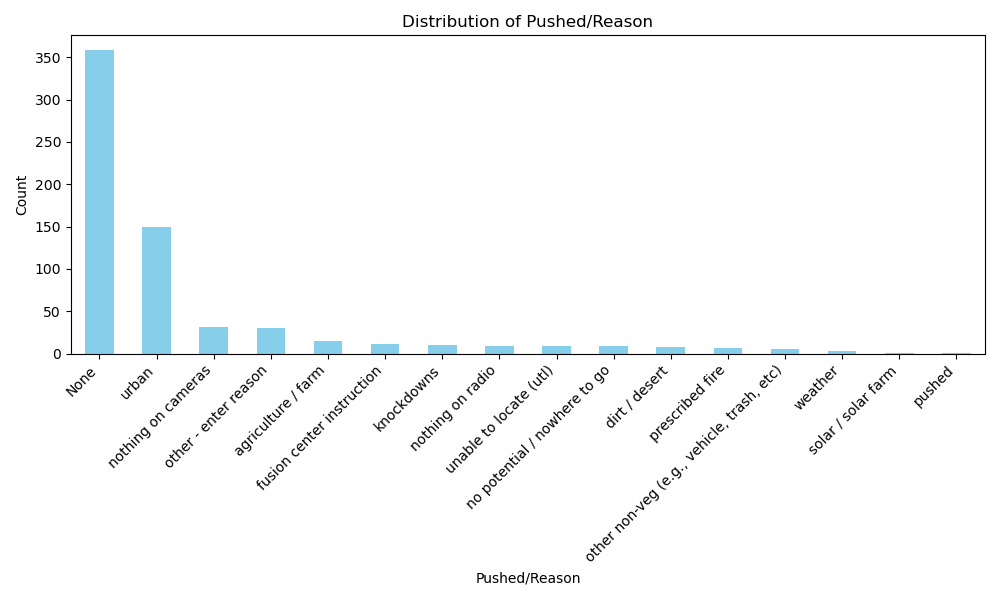

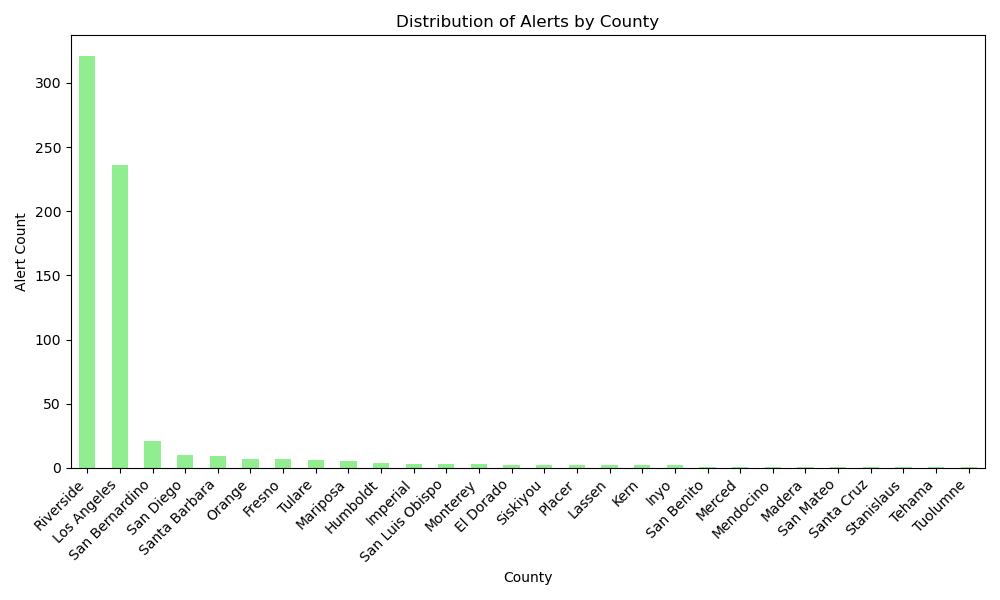

In [61]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### February 2024

In [62]:
# Get feb dataframe
df = dataframes['2024_02']

In [63]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2024_02')

Output()

Output()

In [64]:
create_alerts_choropleth(dataframes, counties, '2024_02')

interactive(children=(Dropdown(description='Month:', index=13, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 417
Average Alert Count: 18.130434782608695
County with Most Alerts: Riverside with 221 alerts
Most Common Reason for Alerts: urban with 92 alerts


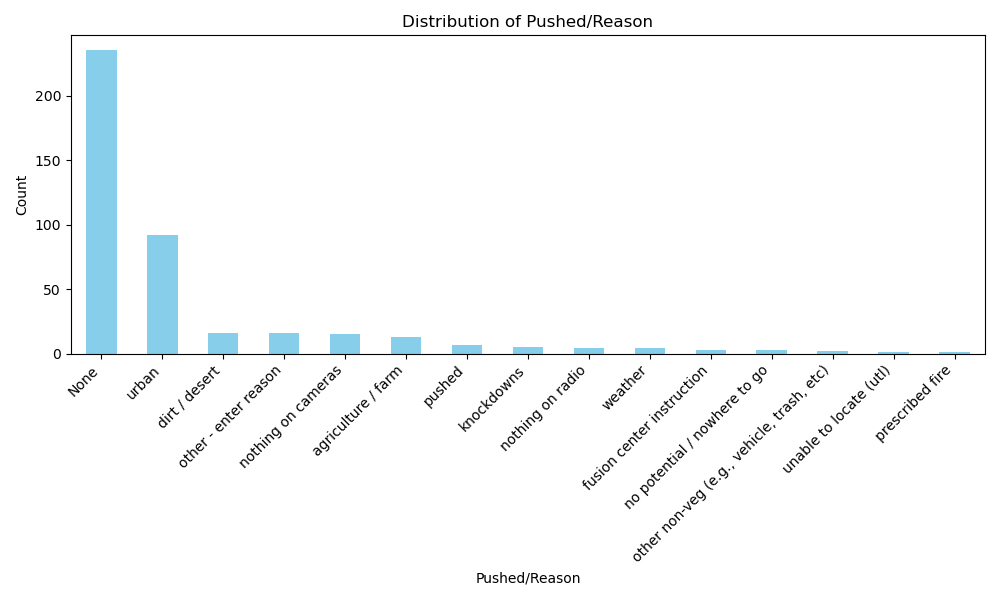

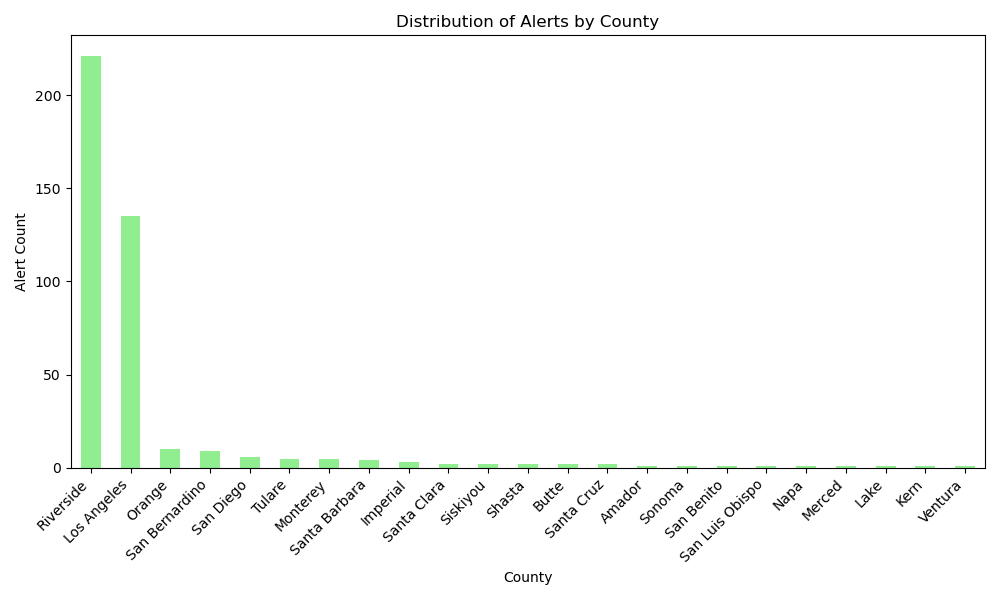

In [65]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### March 2024

In [66]:
# Get march dataframe
df = dataframes['2024_03']

In [67]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2024_03')

Output()

Output()

In [68]:
create_alerts_choropleth(dataframes, counties, '2024_03')

interactive(children=(Dropdown(description='Month:', index=14, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 484
Average Alert Count: 10.083333333333334
County with Most Alerts: Los Angeles with 201 alerts
Most Common Reason for Alerts: urban with 80 alerts


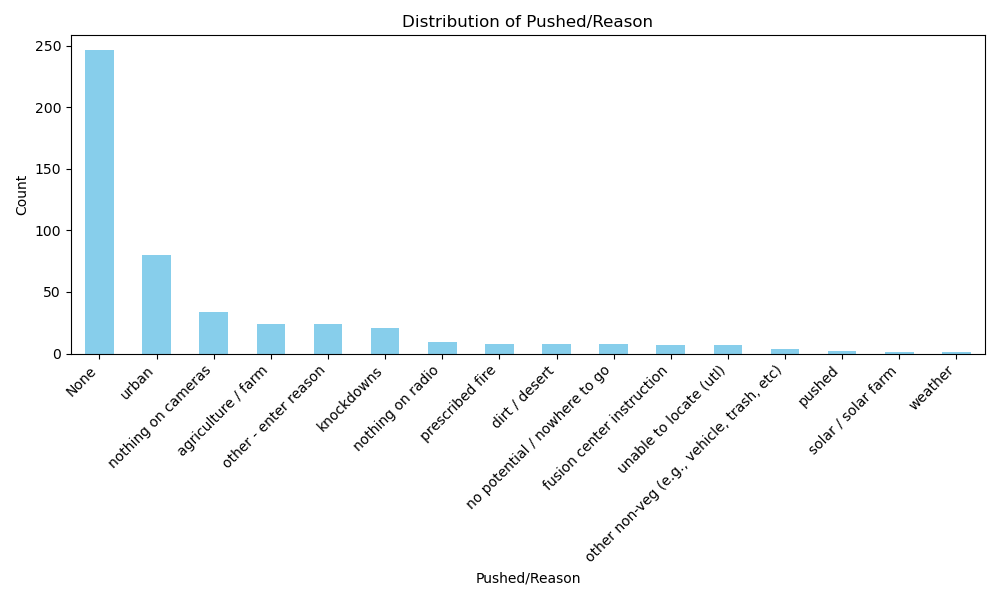

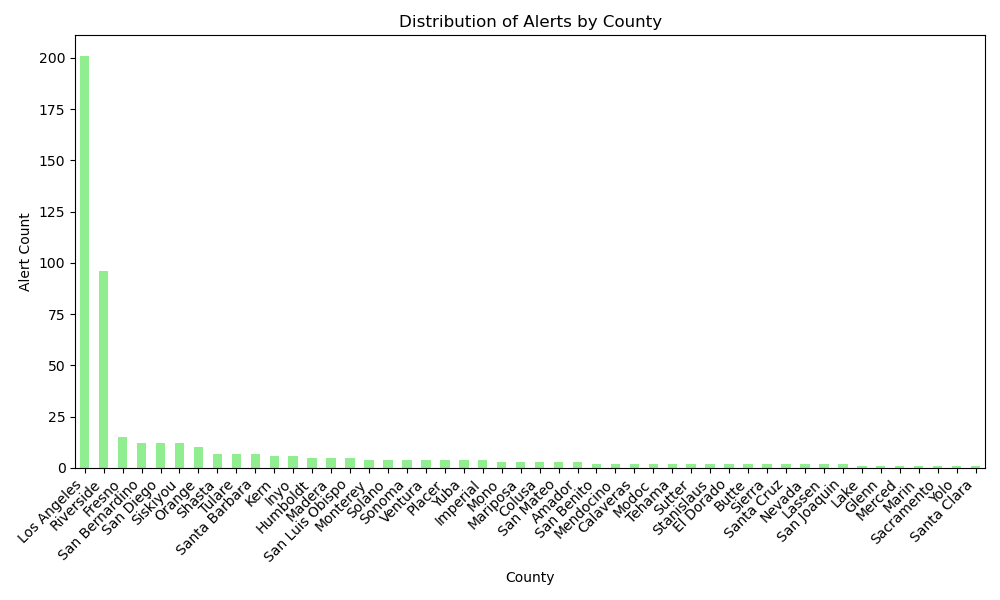

In [69]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### April 2024

In [70]:
# Get april dataframe
df = dataframes['2024_04']

In [71]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2024_04')

Output()

Output()

In [72]:
create_alerts_choropleth(dataframes, counties, '2024_04')

interactive(children=(Dropdown(description='Month:', index=15, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 868
Average Alert Count: 15.672727272727272
County with Most Alerts: Los Angeles with 197 alerts
Most Common Reason for Alerts: agriculture / farm with 140 alerts


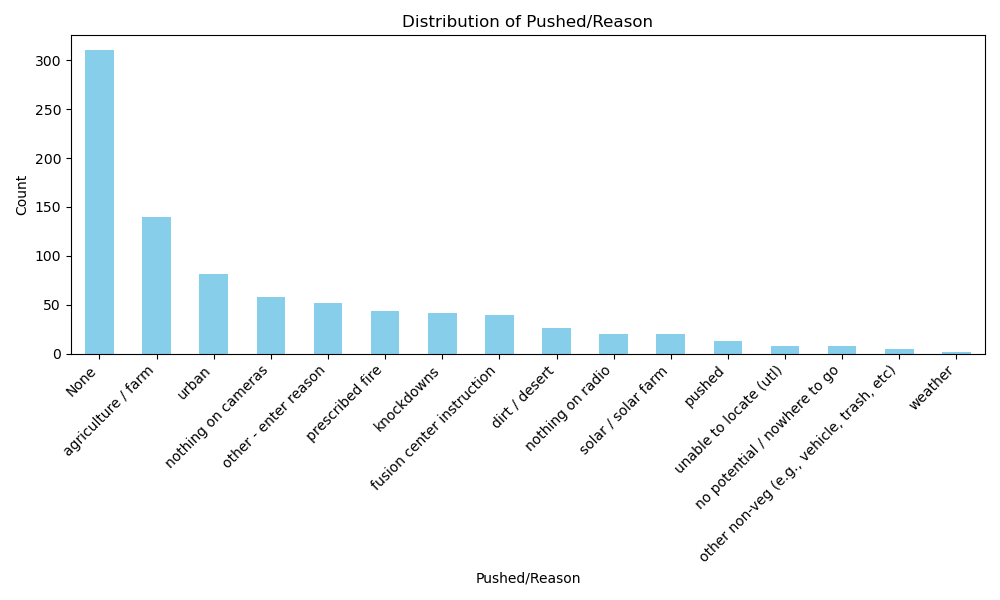

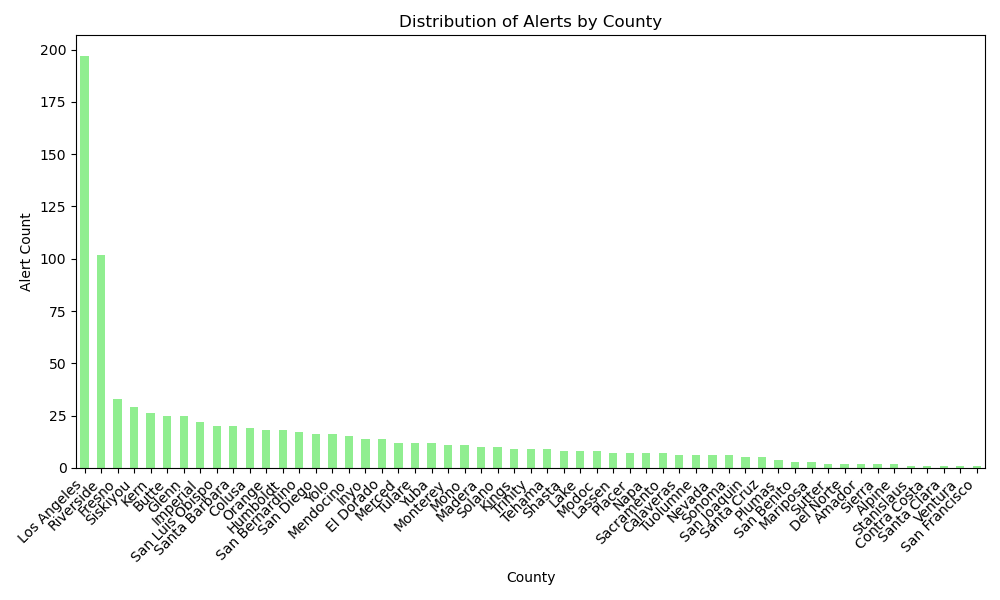

In [73]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### May 2024

In [74]:
# Get may dataframe
df = dataframes['2024_05']

In [75]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2024_05')

Output()

Output()

In [76]:
create_alerts_choropleth(dataframes, counties, '2024_05')

interactive(children=(Dropdown(description='Month:', index=16, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 2062
Average Alert Count: 36.69642857142857
County with Most Alerts: Los Angeles with 272 alerts
Most Common Reason for Alerts: solar / solar farm with 270 alerts


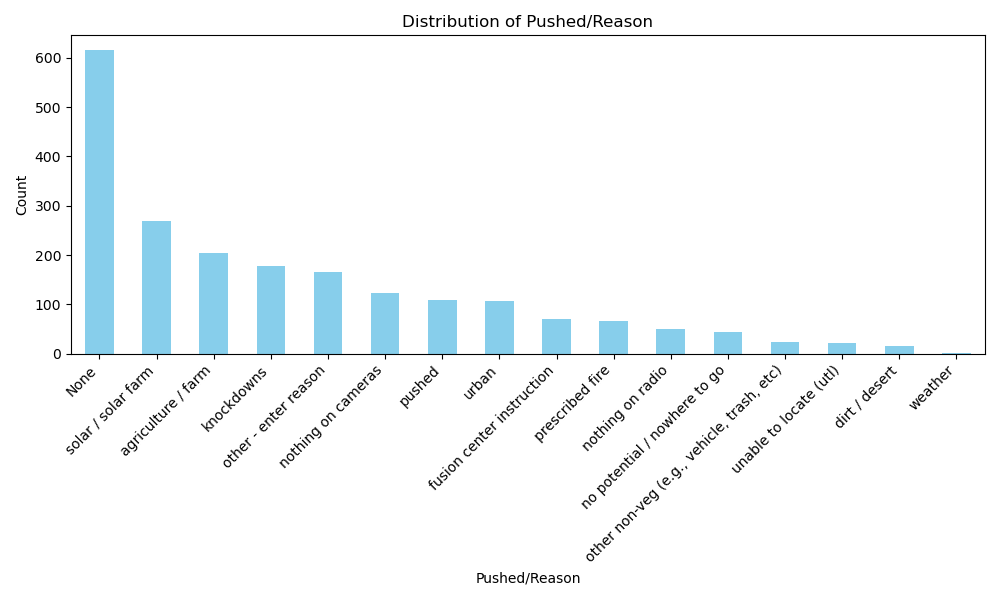

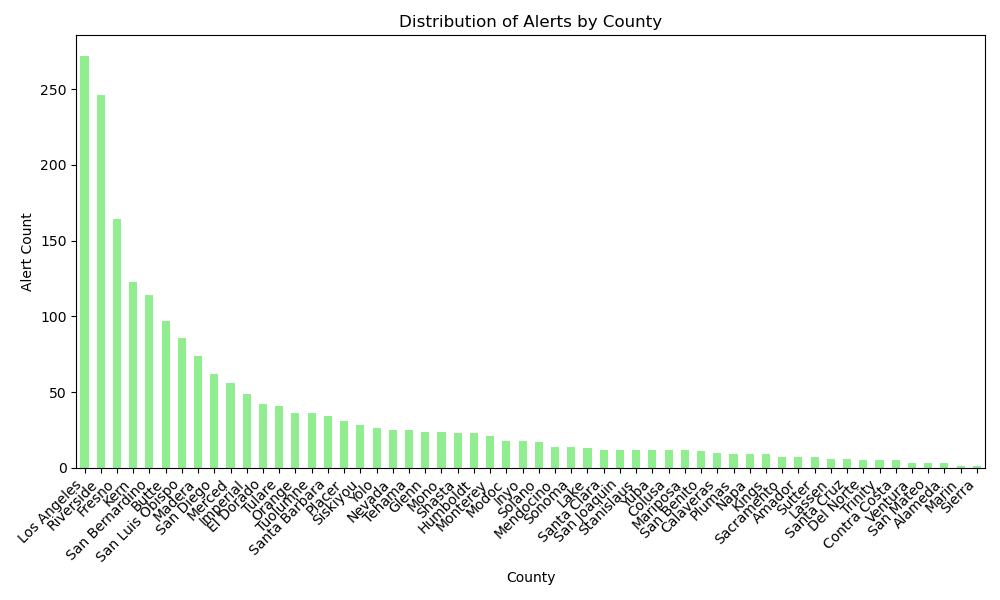

In [77]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### June 2024

In [78]:
# Get june dataframe
df = dataframes['2024_06']

In [79]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2024_06')

Output()

Output()

In [80]:
create_alerts_choropleth(dataframes, counties, '2024_06')

interactive(children=(Dropdown(description='Month:', index=17, options=('2023_01', '2023_02', '2023_03', '2023…

Output()

Total Alert Count: 3150
Average Alert Count: 54.05172413793103
County with Most Alerts: Los Angeles with 471 alerts
Most Common Reason for Alerts: solar / solar farm with 364 alerts


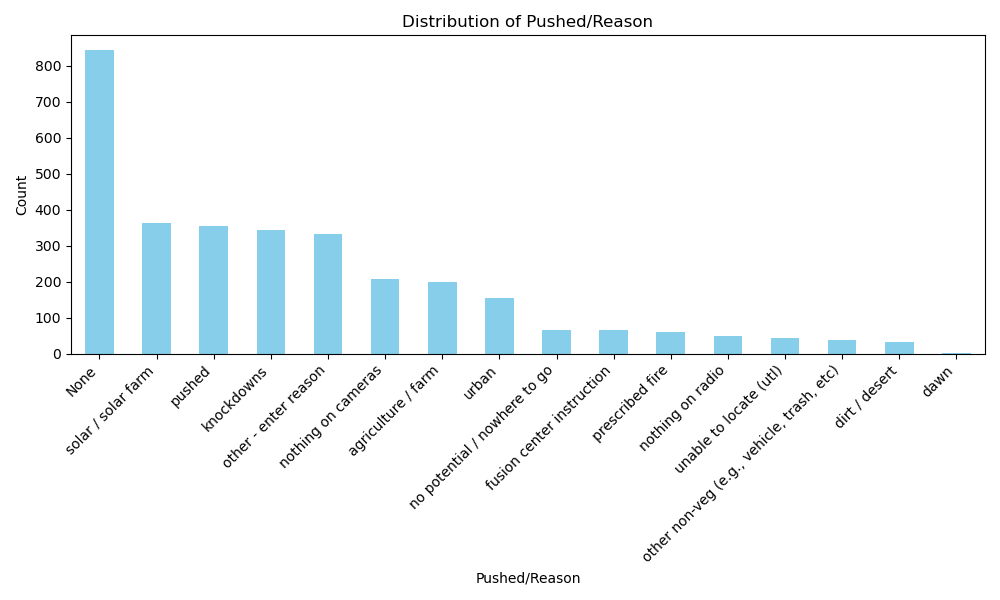

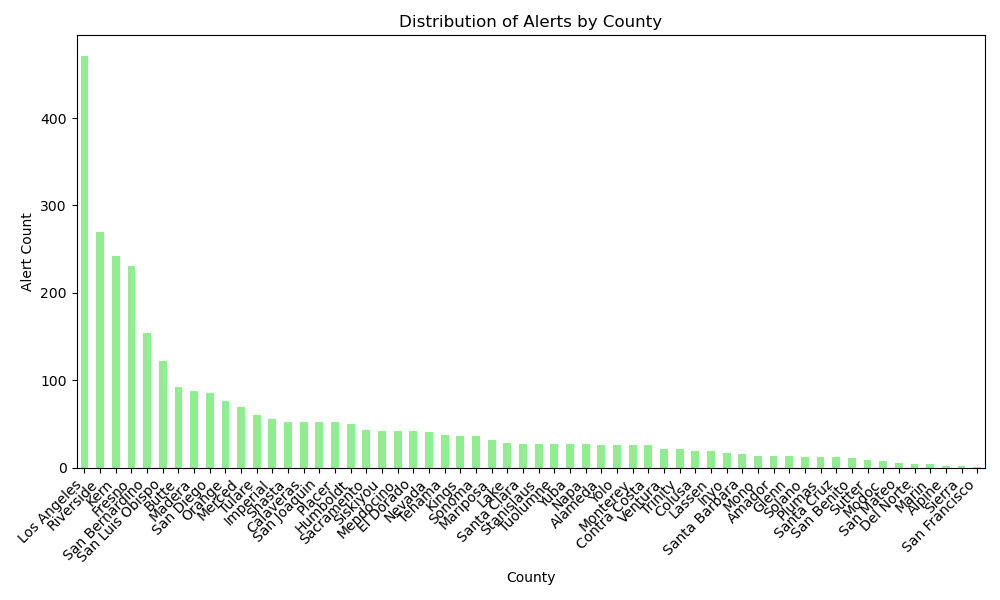

In [81]:
stats = get_alerts_statistics(df, counties)

# Display stats
print(f"Total Alert Count: {stats['total_alert_count']}")
print(f"Average Alert Count: {stats['average_alert_count']}")
print(f"County with Most Alerts: {stats['county_most_alerts']['NAME']} with {stats['county_most_alerts']['alerts_count']} alerts")
print(f"Most Common Reason for Alerts: {stats['most_common_reason']} with {stats['most_common_reason_count']} alerts")
display(Image(filename=stats['pushed_reason_distribution_chart']))
display(Image(filename=stats['county_alerts_distribution_chart']))

### July 2024

In [82]:
# Get july dataframe
df = dataframes['2024_07']

In [83]:
# Get alert count heatmap
create_alerts_heatmap(dataframes, counties, '2024_07')

Output()

Output()

In [84]:
create_alerts_choropleth(dataframes, counties, '2024_07')

interactive(children=(Dropdown(description='Month:', index=18, options=('2023_01', '2023_02', '2023_03', '2023…

Output()